##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 심층 합성곱 생성적 적대 신경망

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/dcgan">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    TensorFlow.org에서 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    구글 코랩(Colab)에서 실행하기</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/generative/dcgan.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    깃허브(GitHub)소스 보기</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/generative/dcgan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: 이 문서는 텐서플로 커뮤니티에서 번역했습니다. 커뮤니티 번역 활동의 특성상 정확한 번역과 최신 내용을 반영하기 위해 노력함에도
불구하고 [공식 영문 문서](https://www.tensorflow.org/?hl=en)의 내용과 일치하지 않을 수 있습니다.
이 번역에 개선할 부분이 있다면
[tensorflow/docs-l10n](https://github.com/tensorflow/docs-l10n/) 깃헙 저장소로 풀 리퀘스트를 보내주시기 바랍니다.
문서 번역이나 리뷰에 참여하려면
[docs-ko@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ko)로
메일을 보내주시기 바랍니다.

이 튜토리얼은 [심층 합성곱 생성적 적대 신경망](https://arxiv.org/pdf/1511.06434.pdf) (Deep Convolutional Generative Adversarial Networks, DCGAN)을 이용하여, 손으로 쓴 숫자들을 어떻게 생성할 수 있는지 보여줍니다. 이 코드는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras)와 `tf.GradientTape` 훈련 루프를 사용하여 작성됐습니다.

## 생성적 적대 신경망(GANs)은 무엇인가요?

[생성적 적대 신경망](https://arxiv.org/abs/1406.2661) (Generative Adversarial Networks, GANs)은 요즘 컴퓨터 과학에서 가장 흥미로운 아이디어 중 하나입니다. 두개의 모델이 적대적인 과정을 통해 동시에 훈련됩니다. *생성자* ("예술가")는 진짜처럼 보이는 이미지를 생성하도록 배우는 와중에, *감별자* ("예술비평가")는 가짜의 이미지로부터 진짜를 구별하게 되는 것을 배우게 됩니다.

![생성자와 감별자를 그린 도표](https://tensorflow.org/tutorials/generative/images/gan1.png)



훈련과정 동안 *생성자*는 점차 실제같은 이미지를 더 잘 생성하게 되고, *감별자*는 점차 진짜와 가짜를 더 잘 구별하게됩니다. 이 과정은 *감별자*가 가짜 이미지에서 진짜 이미지를 더이상 구별하지 못하게 될때, 평형상태에 도달하게 됩니다.

![생성자와 감별자를 그린 두번째 도표](https://tensorflow.org/tutorials/generative/images/gan2.png)

이 노트북은 이 과정을 MNIST 데이터를 이용하여 보여줍니다. 아래의 애니메이션은 50 에포크(epoch)동안 훈련한 *생성자*가 생성해낸 연속된 이미지들을 보여줍니다. 이미지들은 랜덤한 잡음으로 부터 시작되었고, 점차 시간이 지남에 따라 손으로 쓴 숫자들을 닮아가게 됩니다.

![출력 예시](https://tensorflow.org/images/gan/dcgan.gif)

생성적 적대 신경망 (GANs)에 대해 더 배우고 싶으시다면, MIT의 [Intro to Deep Learning](http://introtodeeplearning.com/) 수업을 추천합니다.

### 텐서플로와 다른 라이브러리 불러오기

In [2]:
# !pip install -q tensorflow-gpu==2.0.0-rc1

In [3]:
import tensorflow as tf

In [4]:
tf.__version__

'2.17.0'

In [5]:
# GIF를 만들기위해 설치합니다.
!pip install -q imageio

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

### 데이터셋 로딩 및 준비
생성자와 감별자를 훈련하기위해 MNIST 데이터셋을 사용할것입니다. 생성자는 손글씨 숫자 데이터를 닮은 숫자들을 생성할 것입니다.

In [7]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [9]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [10]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 모델 만들기
생성자와 감별자는 [케라스 Sequential API](https://www.tensorflow.org/guide/keras#sequential_model)를 이용해 정의됩니다.

### 생성자

생성자는 시드값 (seed; 랜덤한 잡음)으로부터 이미지를 생성하기 위해, `tf.keras.layers.Conv2DTranspose` (업샘플링) 층을 이용합니다. 처음 `Dense`층은 이 시드값을 인풋으로 받습니다. 그 다음 원하는 사이즈 28x28x1의 이미지가 나오도록 업샘플링을 여러번 합니다. tanh를 사용하는 마지막 층을 제외한 나머지 각 층마다 활성함수로 `tf.keras.layers.LeakyReLU`을 사용하고 있음을 주목합시다.

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

(아직 훈련이 되지않은) 생성자를 이용해 이미지를 생성해봅시다.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


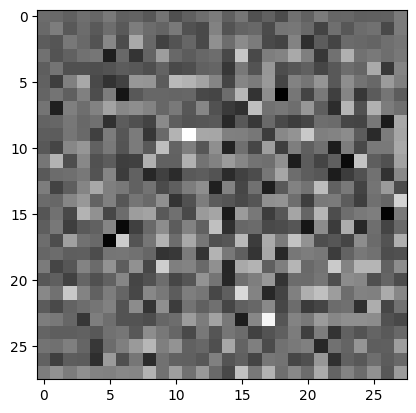

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 감별자
감별자는 합성곱 신경망(Convolutional Neural Network, CNN) 기반의 이미지 분류기입니다.

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

(아직까지 훈련이 되지 않은) 감별자를 사용하여, 생성된 이미지가 진짜인지 가짜인지 판별합니다. 모델은 진짜 이미지에는 양수의 값 (positive values)을, 가짜 이미지에는 음수의 값 (negative values)을 출력하도록 훈련되어집니다.

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00253571]], shape=(1, 1), dtype=float32)


## 손실함수와 옵티마이저 정의
두 모델의 손실함수와 옵티마이저를 정의합니다.

In [15]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### 감별자 손실함수

이 메서드는 감별자가 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화합니다. 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 가짜 (생성된) 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교합니다.

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 생성자 손실함수

생성자의 손실함수는 감별자를 얼마나 잘 속였는지에 대해 수치화를 합니다. 직관적으로 생성자가 원활히 수행되고 있다면, 감별자는 가짜 이미지를 진짜 (또는 1)로 분류를 할 것입니다. 여기서 우리는 생성된 이미지에 대한 감별자의 결정을 1로 이루어진 행렬과 비교를 할 것입니다.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

감별자와 생성자는 따로 훈련되기 때문에, 감별자와 생성자의 옵티마이저는 다릅니다.

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 체크포인트 저장
이 노트북은 오랫동안 진행되는 훈련이 방해되는 경우에 유용하게 쓰일 수 있는 모델의 저장방법과 복구방법을 보여줍니다.

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 훈련 루프 정의하기

In [20]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다.
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

훈련 루프는 생성자가 입력으로 랜덤시드를 받는 것으로부터 시작됩니다. 그 시드값을 사용하여 이미지를 생성합니다. 감별자를 사용하여 (훈련 세트에서 갖고온) 진짜 이미지와 (생성자가 생성해낸) 가짜이미지를 분류합니다. 각 모델의 손실을 계산하고, 그래디언트 (gradients)를 사용해 생성자와 감별자를 업데이트합니다.

In [21]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**이미지 생성 및 저장**


In [23]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## 모델 훈련
위에 정의된 `train()` 메서드를 생성자와 감별자를 동시에 훈련하기 위해 호출합니다. 생성적 적대 신경망을 학습하는 것은 매우 까다로울 수 있습니다. 생성자와 감별자가 서로를 제압하지 않는 것이 중요합니다. (예를 들어 학습률이 비슷하면 한쪽이 우세해집니다.)
훈련 초반부에는 생성된 이미지는 랜덤한 노이즈처럼 보입니다. 훈련이 진행될수록, 생성된 숫자는 점차 진짜처럼 보일 것입니다. 약 50 에포크가 지난 후, MNIST 숫자와 닮은 이미지가 생성됩니다. 코랩에서 기본 설정으로 실행하면, 에포크마다 10~12초정도 소요될 것입니다.

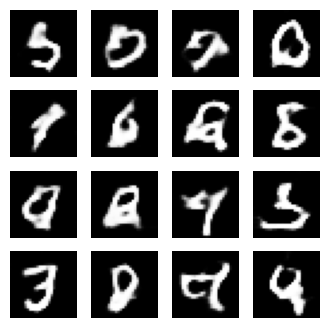

CPU times: user 2min 24s, sys: 18.7 s, total: 2min 43s
Wall time: 1min 54s


In [24]:
%%time
train(train_dataset, EPOCHS)

마지막 체크포인트를 복구합니다.

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## GIF 생성

In [31]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

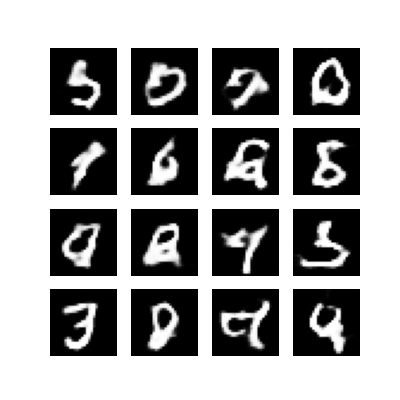

In [32]:
display_image(EPOCHS)

`imageio`로 훈련 중에 저장된 이미지를 사용해 GIF 애니메이션을 만듭니다.

In [33]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-33-880e85e12649>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-33-880e85e12649>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


코랩에서 작업하고 있다면, 아래의 코드에서 애니메이션을 다운로드 받을 수 있습니다:

In [34]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 다음 단계

이 튜토리얼은 생성적 적대 신경망을 만들고 훈련하기에 필요한 코드를 보여줍니다. 다음 단계로, 다른 데이터셋을 이용하여 실험해보고 싶을 수도 있습니다. 예를 들면 [캐글에 올라온](https://www.kaggle.com/jessicali9530/celeba-dataset) 대규모 연예인 얼굴 데이터셋 (Large-scale Celeb Faces Attributes (CelebA))이 있습니다. 생성적 적대 신경망에 대해 더 배우기 원한다면, [NIPS 2016 튜토리얼: 생성적 적대 신경망](https://arxiv.org/abs/1701.00160)을 추천합니다.